## Installing and Importing Dependencies

In [2]:
!pip install opencv-python matplotlib imageio gdown tensorflow

# opencv - preprocessing
# matplotlib - rendering the results (seeing outputs of preprocessed videos)
# imageio - to see other frames stacked together
# gdown - downloading dataset
# tensorflow - building neural network

   ---------------------------------------- 0.0/38.8 MB ? eta -:--:--
   ---------------------------------------- 0.3/38.8 MB ? eta -:--:--
   - -------------------------------------- 1.0/38.8 MB 3.4 MB/s eta 0:00:12
   -- ------------------------------------- 2.1/38.8 MB 3.9 MB/s eta 0:00:10
   -- ------------------------------------- 2.9/38.8 MB 4.2 MB/s eta 0:00:09
   ---- ----------------------------------- 4.2/38.8 MB 4.5 MB/s eta 0:00:08
   ----- ---------------------------------- 5.2/38.8 MB 4.7 MB/s eta 0:00:08
   ------ --------------------------------- 6.3/38.8 MB 4.8 MB/s eta 0:00:07
   ------- -------------------------------- 7.6/38.8 MB 4.9 MB/s eta 0:00:07
   -------- ------------------------------- 8.7/38.8 MB 5.0 MB/s eta 0:00:07
   ---------- ----------------------------- 10.0/38.8 MB 5.1 MB/s eta 0:00:06
   ----------- ---------------------------- 11.3/38.8 MB 5.2 MB/s eta 0:00:06
   ------------ --------------------------- 12.6/38.8 MB 5.3 MB/s eta 0:00:05
   -------

In [4]:
!pip list

Package                           Version
--------------------------------- ------------------
absl-py                           2.1.0
aext-assistant                    4.0.15
aext-assistant-server             4.0.15
aext-core                         4.0.15
aext-core-server                  4.0.15
aext-panels                       4.0.15
aext-panels-server                4.0.15
aext-share-notebook               4.0.15
aext-share-notebook-server        4.0.15
aext-shared                       4.0.15
aiobotocore                       2.12.3
aiohappyeyeballs                  2.4.0
aiohttp                           3.10.5
aioitertools                      0.7.1
aiosignal                         1.2.0
alabaster                         0.7.16
altair                            5.0.1
anaconda-anon-usage               0.4.4
anaconda-catalogs                 0.2.0
anaconda-client                   1.12.3
anaconda-cloud-auth               0.5.1
anaconda-navigator                2.6.3
anaconda-pro

In [3]:
import os # navigating through file systems in different operating systems
import cv2 # preprocessing and loading videos
import tensorflow as tf # modelling (tf.data - good data pipeline)
import numpy as np 
from typing import List 
import matplotlib.pyplot as plt
import imageio # array to a gif for preprocess

In [5]:
tf.config.list_physical_devices('GPU')

[]

In [7]:
# Preventing exponential memory growth
physical_device = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

## Building Data Loading Functions

1. to load up videos
2. preprocess annotations (sentences and video lyrics)

In [11]:
import gdown

In [13]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8Jwjl'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

FileURLRetrievalError: Failed to retrieve file url:

	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses.
	Check FAQ in https://github.com/wkentaro/gdown?tab=readme-ov-file#faq.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8Jwjl

but Gdown can't. Please check connections and permissions.

In [15]:
# Data loading function

# take the data path and put a list of float represents a video
def load_video(path:str) -> List[float]:

    # creating cv2 instances and then looping through each of them and storing in array called frames
    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236, 80:220, :])  # isolating mouth position
    cap.release()

    # scaling particular image features + 
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [17]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [19]:
# Converting nums to chars and vice versa (tokenizing each char)

# https://keras.io/examples/audio/ctc_asr/

# here i'm able to pass through this data to our loss function to calculate our overall loss bcs model gonna return one-hot-encoded version of this

char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)


print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [21]:
char_to_num(['a', 'l', 'm', 'a'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([ 1, 12, 13,  1], dtype=int64)>

In [23]:
char_to_num(['2', '0', '1', '4'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([31,  0, 30, 33], dtype=int64)>

In [25]:
# Function load to alignments

def load_alignments(path:str) -> List[str]: 

    # reading lines from a path into a list
    with open(path, 'r') as f: 
        lines = f.readlines() 

    # splitting up lines
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':   # line converts silence, we'll ignore it

            # appending them to a list named 'tokens'
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [27]:
# Loading the alignments and videos simultaneously.
# Extracting both of those paths and returning preprocessed videos + alignments together

def load_data(path: str): 
    path = bytes.decode(path.numpy())
    #file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [29]:
test_path = '.\\data\\s1\\bbal6n.mpg'

In [31]:
tf.convert_to_tensor(test_path)

<tf.Tensor: shape=(), dtype=string, numpy=b'.\\data\\s1\\bbal6n.mpg'>

In [33]:
tf.convert_to_tensor(test_path).numpy()

b'.\\data\\s1\\bbal6n.mpg'

In [35]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

'bbal6n'

In [37]:
load_data(tf.convert_to_tensor(test_path))

# frames, height, width, number of channels(grayscale)

(<tf.Tensor: shape=(75, 46, 140, 1), dtype=float32, numpy=
 array([[[[ 1.4603739 ],
          [ 1.4603739 ],
          [ 1.4209043 ],
          ...,
          [ 0.15787826],
          [ 0.19734782],
          [ 0.07893913]],
 
         [[ 1.4603739 ],
          [ 1.4603739 ],
          [ 1.4209043 ],
          ...,
          [ 0.15787826],
          [ 0.07893913],
          [ 0.03946957]],
 
         [[ 1.4209043 ],
          [ 1.4209043 ],
          [ 1.3814348 ],
          ...,
          [ 0.07893913],
          [ 0.07893913],
          [ 0.07893913]],
 
         ...,
 
         [[ 0.94726956],
          [ 0.94726956],
          [ 0.94726956],
          ...,
          [ 9.94633   ],
          [ 9.867392  ],
          [ 9.867392  ]],
 
         [[ 0.94726956],
          [ 0.94726956],
          [ 0.94726956],
          ...,
          [ 9.90686   ],
          [ 9.867392  ],
          [ 9.867392  ]],
 
         [[ 0.94726956],
          [ 0.94726956],
          [ 0.94726956],
          

In [38]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

In [41]:
frames

<tf.Tensor: shape=(75, 46, 140, 1), dtype=float32, numpy=
array([[[[ 1.4603739 ],
         [ 1.4603739 ],
         [ 1.4209043 ],
         ...,
         [ 0.15787826],
         [ 0.19734782],
         [ 0.07893913]],

        [[ 1.4603739 ],
         [ 1.4603739 ],
         [ 1.4209043 ],
         ...,
         [ 0.15787826],
         [ 0.07893913],
         [ 0.03946957]],

        [[ 1.4209043 ],
         [ 1.4209043 ],
         [ 1.3814348 ],
         ...,
         [ 0.07893913],
         [ 0.07893913],
         [ 0.07893913]],

        ...,

        [[ 0.94726956],
         [ 0.94726956],
         [ 0.94726956],
         ...,
         [ 9.94633   ],
         [ 9.867392  ],
         [ 9.867392  ]],

        [[ 0.94726956],
         [ 0.94726956],
         [ 0.94726956],
         ...,
         [ 9.90686   ],
         [ 9.867392  ],
         [ 9.867392  ]],

        [[ 0.94726956],
         [ 0.94726956],
         [ 0.94726956],
         ...,
         [ 9.90686   ],
         [ 9.86739

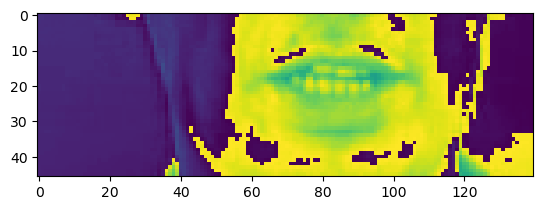

In [43]:
plt.imshow(frames[40])

# result of subtracting mean and std

In [45]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23], dtype=int64)>

In [47]:
# ERROR
num_to_char(alignments.numpy()).numpy().decode('utf-8')

AttributeError: 'numpy.ndarray' object has no attribute 'decode'

In [49]:
print([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

['b', 'i', 'n', ' ', 'b', 'l', 'u', 'e', ' ', 'a', 't', ' ', 'l', ' ', 's', 'i', 'x', ' ', 'n', 'o', 'w']


In [51]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [53]:
# Wrapping inside a mappable function that returns float32 and int64, using rawstring processing + assit in tensorflow pipelines

def mappable_function(path:str) -> List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

## Data Pipelines
For training Deep Learning model: 
1. Tensorflow will draw random samples from our dataset in order to complete 1 training step.
2. Checking transformation is succesful.

In [57]:
import matplotlib.pyplot as plt

In [59]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')  # creating dataset
data = data.shuffle(500, reshuffle_each_iteration=False)  # shuffling the first 500
data = data.map(mappable_function)  # from data ocation to data itself
data = data.padded_batch(2, padded_shapes=([75, None, None, None], [40]))  # (2 videos + 2 sets of alignments), 75 frames, no pad img, 40 tokens
data = data.prefetch(tf.data.AUTOTUNE)  # !!! PREFETCHING


In [61]:
frames, alignments = data.as_numpy_iterator().next()

In [62]:
len(frames)

2

In [65]:
test = data.as_numpy_iterator()

In [67]:
val = test.next(); val[0]

array([[[[[1.4908065 ],
          [1.4553111 ],
          [1.4553111 ],
          ...,
          [0.39044932],
          [0.39044932],
          [0.39044932]],

         [[1.4908065 ],
          [1.4553111 ],
          [1.4553111 ],
          ...,
          [0.39044932],
          [0.39044932],
          [0.39044932]],

         [[1.3843203 ],
          [1.3843203 ],
          [1.3133296 ],
          ...,
          [0.3549539 ],
          [0.3549539 ],
          [0.3549539 ]],

         ...,

         [[0.993871  ],
          [0.993871  ],
          [0.993871  ],
          ...,
          [0.07099079],
          [0.07099079],
          [0.07099079]],

         [[0.993871  ],
          [0.993871  ],
          [0.993871  ],
          ...,
          [0.07099079],
          [0.07099079],
          [0.07099079]],

         [[0.993871  ],
          [0.993871  ],
          [0.993871  ],
          ...,
          [0.07099079],
          [0.07099079],
          [0.03549539]]],


        [[[1.5263

In [69]:
import warnings
warnings.filterwarnings('ignore')

In [71]:
imageio.mimsave('./animation.gif', val[0][1], fps = 10)  # bsc 0 or 1 - 2 sets of videos

Lossy conversion from float32 to uint8. Range [0.0, 9.72919750213623]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.72919750213623]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.72919750213623]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.72919750213623]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.72919750213623]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.72919750213623]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.72919750213623]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

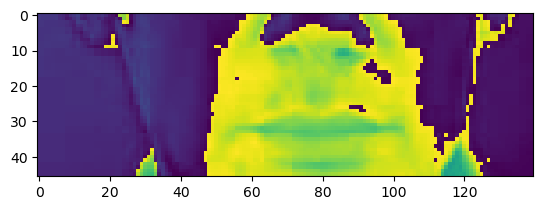

In [73]:
plt.imshow(val[0][0][0])  # videos, give me the first of the batch, return the first frame in the video

In [75]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])  # preprocessed annotation

<tf.Tensor: shape=(), dtype=string, numpy=b'bin green by b three again'>

## Design the Deep Neural Network
1. 3D convolutions to pass the videos
2. Condensing it down to a classification dense layer to predict characters
3. Loss function to predict single letters each time (**CTC - Connectionist Temporal Classification**)

   3.1 Why - works great when there are word transcriptions that aren't specifically aligned to frames (**`research - standard cross-entropy loss function`**)
   
   3.2 Reduces duplicates using special tokens
   
   3.3 Dataset was aligned? - when it comes to subbing out the data with data we created, it's gonna be way more cost-effective to use non-aligned data. 

In [79]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler